首先，需要安装deap(GA的标准库)和bitstring，这两个库用于训练网络

In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import CuDNNLSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt

np.random.seed(1120)

导入数据集

In [6]:
dataset = pd.read_csv("aqi_eemd_out.csv")
Y=dataset.IMF1Y
X=dataset.drop('IMF1Y',axis=1)
data=np.array(X)

处理标签

In [7]:
#convert Y(output label) to numpy array
y = Y.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
encoded_y = min_max_scaler.fit_transform(data)
print(encoded_y)

[[0.35163437]
 [0.5864258 ]
 [0.34064417]
 [0.54896157]
 [0.35297753]
 [0.60197102]
 [0.57834657]
 [0.24351036]
 [0.29895783]
 [0.38417486]
 [0.57553939]
 [0.34543667]
 [0.61603628]
 [0.39430006]
 [0.10116474]
 [0.8426602 ]
 [0.2697265 ]
 [0.17980671]
 [0.68274708]
 [0.34392951]
 [0.19817876]
 [0.46311312]
 [0.7870563 ]
 [0.57753368]
 [0.16863724]
 [0.40631618]
 [0.6128623 ]
 [0.33679032]
 [0.57446282]
 [0.31182459]
 [0.63644881]
 [0.6111173 ]
 [0.31431582]
 [0.16134979]
 [0.21252922]
 [0.53784315]
 [0.74143741]
 [0.72365571]
 [0.62234259]
 [0.42660093]
 [0.36792775]
 [0.53555629]
 [0.33976445]
 [0.40877419]
 [0.48526108]
 [0.80935822]
 [0.58658216]
 [0.00796409]
 [0.03838245]
 [0.13412085]
 [0.59445399]
 [0.8007033 ]
 [0.55174018]
 [0.08229919]
 [0.1278129 ]
 [0.57747506]
 [0.84071073]
 [0.16095775]
 [0.64392509]
 [0.31329258]
 [0.51463494]
 [0.70582551]
 [0.09518505]
 [0.10840647]
 [0.23414838]
 [0.36193291]
 [0.69320317]
 [0.41117673]
 [0.27403021]
 [0.66620405]
 [0.19110483]
 [0.37

In [11]:
def cal_rmse(y_test, yhat):
    return (((y_test - yhat)**2).mean())**0.5

In [28]:
def train_evaluate(ga_individual_solution):
    #开始进行解码，将神经元的数量，epoch还有batchsize 这些进行处理
    # Decode GA solution to integer for num_neurons1, epochs and batch_size 
    #在内部进行初始化，否则回报错
    min_max_scaler = preprocessing.MinMaxScaler()
    x_train_scaled = min_max_scaler.fit_transform(data)
    
    num_neurons1_bits = BitArray(ga_individual_solution[0:9])
    num_neurons2_bits = BitArray(ga_individual_solution[9:18])
    epoch_bits = BitArray(ga_individual_solution[18:25]) 
    batch_size_bits = BitArray(ga_individual_solution[25:35])
    learning_rate_bits = BitArray(ga_individual_solution[35:])
   
    num_neurons1 = num_neurons1_bits.uint
    num_neurons2 = num_neurons2_bits.uint
    epoch = epoch_bits.uint
    Batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    learning_rate = temp*(math.exp(-9))
    
    print('\nNum of neurons1: ', num_neurons1,'\nNum of neurons2',num_neurons2, '\nEpoch:', epoch,'\nBatch size:',Batch_size,'\nLearning rate:',learning_rate)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if num_neurons1 < 100 or num_neurons2 < 100 or epoch < 100 or Batch_size < 500  or learning_rate < 0:
      return 0,
    
    #split into train and validation (80/20)
    x_train,x_test,y_train,y_test=train_test_split(x_train_scaled,encoded_y,test_size=0.2)
    
    #converting the input train and test set to array format
    x_train=np.array(x_train)
    x_test=np.array(x_test)
    
    #reshape input data according to LSTM model requirements
    x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
    x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])
    
    #Design the LSTM model
    #LSTM的优化方法，这里可以注意一下，按照Adam的优化方法进行计算
    optimizer=optimizers.adam_v2.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model = Sequential()
    model.add(CuDNNLSTM(num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(CuDNNLSTM(num_neurons2))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    history=model.fit(x_train_modified, y_train, epochs=epoch, batch_size=Batch_size,verbose=0)
    y_pred = model.predict(x_test_modified)
    print(y_pred)
    rmse = cal_rmse(y_test, y_pred)
    
    return [rmse]


In [29]:
population_size = 50
num_generations = 10
gene_length = 42

''' 以下是使用deap创造一个遗产算法实例 '''
# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
start_time = datetime.now()
print("Start time:", start_time)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)
end_time = datetime.now()
print('End time:',end_time)
time_elapsed = end_time-start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Start time: 2023-02-26 19:03:02.184127

Num of neurons1:  152 
Num of neurons2 185 
Epoch: 62 
Batch size: 277 
Learning rate: 0.012094160800494597

Num of neurons1:  86 
Num of neurons2 263 
Epoch: 65 
Batch size: 315 
Learning rate: 0.007898227461547492

Num of neurons1:  64 
Num of neurons2 382 
Epoch: 101 
Batch size: 750 
Learning rate: 0.00839186667789421

Num of neurons1:  511 
Num of neurons2 272 
Epoch: 125 
Batch size: 273 
Learning rate: 0.0003702294122600387

Num of neurons1:  107 
Num of neurons2 385 
Epoch: 117 
Batch size: 320 
Learning rate: 0.007898227461547492

Num of neurons1:  33 
Num of neurons2 310 
Epoch: 29 
Batch size: 585 
Learning rate: 0.007404588245200774

Num of neurons1:  395 
Num of neurons2 115 
Epoch: 73 
Batch size: 955 
Learning rate: 0.015179405902661586

Num of neurons1:  394 
Num of neurons2 375 
Epoch: 89 
Batch size: 420 
Learning rate: 0.006540719616594017

Num of neurons1:  76 
Num of neurons2 477 
Epoch: 86 
Batch size: 310 
Learning rate: 0.

Total params: 669,599
Trainable params: 669,599
Non-trainable params: 0
_________________________________________________________________


D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[[0.57457227]
 [0.54001814]
 [0.46128398]
 [0.45119956]
 [0.40514436]
 [0.62953085]
 [0.3567779 ]
 [0.35185567]
 [0.3957637 ]
 [1.0057749 ]
 [1.0067849 ]
 [0.410713  ]
 [0.9983757 ]
 [0.53594804]
 [0.27053627]
 [0.8655376 ]
 [0.5061282 ]
 [0.24032359]
 [0.5457684 ]
 [0.57105446]
 [0.29441002]
 [0.47606736]
 [0.49521768]
 [0.81640375]
 [0.48120818]
 [1.0091535 ]
 [0.4541352 ]
 [0.44914547]
 [0.32751524]
 [0.50705826]
 [0.38568196]
 [1.0009838 ]
 [0.6298993 ]
 [0.59361315]
 [1.0054245 ]
 [0.55415636]
 [1.0015637 ]
 [0.9992782 ]
 [0.4755007 ]
 [0.61343396]
 [0.3125747 ]
 [0.6641236 ]
 [0.48691595]
 [0.16330099]
 [0.44511944]
 [0.26458144]
 [0.33048275]
 [0.18496764]
 [1.0065665 ]
 [1.0025192 ]
 [1.0069991 ]
 [0.9976421 ]
 [0.6337405 ]
 [1.008185  ]
 [1.0033714 ]
 [0.2496776 ]
 [0.439904  ]
 [0.3047246 ]
 [0.34856454]
 [1.0073127 ]
 [0.51494   ]
 [0.3594129 ]
 [0.46748033]
 [0.5696955 ]
 [0.5029106 ]
 [0.3328052 ]
 [0.52803904]
 [0.49351895]
 [0.35587612]
 [0.55213517]
 [1.0089351 ]
 [0.05

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_102 (CuDNNLSTM)  (None, 1, 318)            408312    
                                                                 
 dropout_102 (Dropout)       (None, 1, 318)            0         
                                                                 
 cu_dnnlstm_103 (CuDNNLSTM)  (None, 278)               664976    
                                                                 
 dropout_103 (Dropout)       (None, 278)               0         
                                                                 
 dense_51 (Dense)            (None, 1)                 279       
                                                                 
Total params: 1,073,567
Trainable params: 1,073,567
Non-trainable params: 0
_________________________________________________________________
[[0.44053492]
 [0.30859917]
 [0.38946712]
 [0.3297591 ]
 [0.350555

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[[0.3468016 ]
 [0.4003879 ]
 [0.18213774]
 [0.16032186]
 [0.7299735 ]
 [0.34223166]
 [0.2796266 ]
 [0.45267   ]
 [0.3885306 ]
 [0.4602085 ]
 [0.7779722 ]
 [0.04978925]
 [0.32562014]
 [0.36547264]
 [1.0003654 ]
 [0.4040176 ]
 [0.68001246]
 [0.3059908 ]
 [0.2786685 ]
 [0.4771589 ]
 [0.43293476]
 [0.5245842 ]
 [0.38414887]
 [0.4688862 ]
 [0.40687436]
 [0.46281603]
 [0.34281003]
 [1.0035713 ]
 [0.34606653]
 [0.3458497 ]
 [1.0008003 ]
 [0.4045085 ]
 [0.33473662]
 [0.59013766]
 [0.5536273 ]
 [0.5071566 ]
 [1.0107486 ]
 [0.54340494]
 [0.3431038 ]
 [0.51599723]
 [0.3668979 ]
 [0.9997598 ]
 [0.9564253 ]
 [0.3299784 ]
 [0.47105652]
 [0.43146738]
 [0.50528824]
 [0.5920465 ]
 [0.41476285]
 [0.43184593]
 [0.3089383 ]
 [0.46965656]
 [0.53814805]
 [0.50929725]
 [0.29230437]
 [0.1268434 ]
 [0.4275589 ]
 [0.20800124]
 [0.31458965]
 [0.4187245 ]
 [0.5394069 ]
 [0.36410514]
 [0.30896756]
 [0.38862813]
 [0.41929618]
 [0.62226343]
 [1.0099504 ]
 [0.35231373]
 [0.48764247]
 [0.51992357]
 [1.010045  ]
 [0.21

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[[0.43440533]
 [0.51144934]
 [0.35663998]
 [0.5119009 ]
 [0.29242936]
 [0.58476603]
 [0.40530735]
 [0.45861757]
 [0.21225572]
 [0.8226703 ]
 [0.3955215 ]
 [0.50275886]
 [0.5402819 ]
 [0.27286518]
 [1.0131108 ]
 [0.47362375]
 [0.48566455]
 [1.0084984 ]
 [1.013567  ]
 [1.0103226 ]
 [1.0048519 ]
 [0.59452176]
 [1.0128777 ]
 [0.49551365]
 [0.55585915]
 [0.2912532 ]
 [0.26212847]
 [0.45248783]
 [1.0138998 ]
 [1.0154073 ]
 [0.48201922]
 [1.0127603 ]
 [0.58387554]
 [0.17333193]
 [0.34400716]
 [0.50818604]
 [1.0074632 ]
 [0.5783184 ]
 [0.34071675]
 [1.0098293 ]
 [0.46397477]
 [0.42552167]
 [1.0140088 ]
 [0.41339204]
 [0.7816236 ]
 [0.35513875]
 [0.55350876]
 [0.05535074]
 [0.4097451 ]
 [1.0157549 ]
 [0.2779919 ]
 [0.38401476]
 [1.0122843 ]
 [1.0059214 ]
 [1.0105698 ]
 [0.41174653]
 [1.0097065 ]
 [1.0064039 ]
 [1.0120431 ]
 [0.34746072]
 [0.24760985]
 [1.009584  ]
 [0.36856687]
 [1.0124042 ]
 [0.35875714]
 [0.503093  ]
 [0.57296294]
 [0.36541483]
 [0.4948164 ]
 [0.25316662]
 [1.0052284 ]
 [1.00

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[[1.0082057 ]
 [0.2782771 ]
 [0.347983  ]
 [0.5033079 ]
 [0.6793091 ]
 [0.5035969 ]
 [0.4532769 ]
 [0.57992405]
 [0.31308126]
 [0.4027055 ]
 [1.0160775 ]
 [1.0139157 ]
 [0.34840643]
 [0.4177043 ]
 [0.551172  ]
 [0.71102804]
 [0.36030376]
 [0.34434724]
 [0.46473128]
 [1.0068196 ]
 [0.3949535 ]
 [0.80626035]
 [0.67472124]
 [0.4626127 ]
 [0.38504338]
 [0.46308878]
 [0.5168002 ]
 [0.49553755]
 [0.5613672 ]
 [0.3872409 ]
 [0.5097441 ]
 [0.37027958]
 [0.14001787]
 [0.5807555 ]
 [0.41158187]
 [0.37528944]
 [0.40911704]
 [0.47349966]
 [0.45243338]
 [0.64847565]
 [0.8423478 ]
 [0.3314469 ]
 [0.81556827]
 [0.31105465]
 [0.540973  ]
 [0.46518865]
 [0.48188448]
 [0.42196074]
 [0.4126687 ]
 [0.5199155 ]
 [0.5408772 ]
 [0.39039892]
 [0.16071296]
 [0.5421421 ]
 [0.6073359 ]
 [0.5649594 ]
 [0.34892362]
 [1.012067  ]
 [0.44610554]
 [0.5034216 ]
 [0.3449264 ]
 [0.620591  ]
 [1.0177286 ]
 [1.0182812 ]
 [0.49687734]
 [0.51254505]
 [0.3503603 ]
 [0.3199989 ]
 [1.0080019 ]
 [1.0066626 ]
 [0.26507065]
 [0.26

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_110 (CuDNNLSTM)  (None, 1, 343)            474712    
                                                                 
 dropout_110 (Dropout)       (None, 1, 343)            0         
                                                                 
 cu_dnnlstm_111 (CuDNNLSTM)  (None, 164)               333904    
                                                                 
 dropout_111 (Dropout)       (None, 164)               0         
                                                                 
 dense_55 (Dense)            (None, 1)                 165       
                                                                 
Total params: 808,781
Trainable params: 808,781
Non-trainable params: 0
_________________________________________________________________
[[0.39984   ]
 [0.6963459 ]
 [1.0186565 ]
 [0.05746192]
 [0.6509048 ]


D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_112 (CuDNNLSTM)  (None, 1, 164)            109552    
                                                                 
 dropout_112 (Dropout)       (None, 1, 164)            0         
                                                                 
 cu_dnnlstm_113 (CuDNNLSTM)  (None, 415)               964460    
                                                                 
 dropout_113 (Dropout)       (None, 415)               0         
                                                                 
 dense_56 (Dense)            (None, 1)                 416       
                                                                 
Total params: 1,074,428
Trainable params: 1,074,428
Non-trainable params: 0
_________________________________________________________________
[[0.48991185]
 [0.5543677 ]
 [0.8192295 ]
 

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


_________________________________________________________________
[[1.0124466 ]
 [0.5511161 ]
 [1.0074888 ]
 [0.35556197]
 [0.3414431 ]
 [1.0037646 ]
 [0.4473672 ]
 [0.5514795 ]
 [0.31413695]
 [1.0130938 ]
 [0.40832222]
 [0.29832226]
 [0.43963027]
 [0.2063686 ]
 [0.40347645]
 [0.3118952 ]
 [0.6607071 ]
 [0.79405487]
 [0.38030824]
 [0.700875  ]
 [0.26125544]
 [0.70811194]
 [1.0034658 ]
 [0.5962377 ]
 [0.3874299 ]
 [0.4266317 ]
 [0.47648048]
 [0.47317117]
 [0.45621264]
 [0.3501678 ]
 [0.44479516]
 [1.0060893 ]
 [0.5462098 ]
 [1.0077311 ]
 [0.37969282]
 [0.49241695]
 [0.27815   ]
 [1.0039252 ]
 [0.41597307]
 [0.40090954]
 [0.34476003]
 [0.35087177]
 [1.0095835 ]
 [0.5092871 ]
 [1.0131977 ]
 [0.2906507 ]
 [1.0082204 ]
 [0.3509268 ]
 [0.3444918 ]
 [1.003687  ]
 [0.72612333]
 [0.4832313 ]
 [0.37195903]
 [0.46606636]
 [0.15540393]
 [1.0059781 ]
 [1.009211  ]
 [1.0143366 ]
 [0.3457604 ]
 [0.4825545 ]
 [0.6134061 ]
 [0.40070212]
 [0.3488614 ]
 [0.26689318]
 [0.3817536 ]
 [1.0117643 ]
 [0.562522

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
Total params: 808,781
Trainable params: 808,781
Non-trainable params: 0
_________________________________________________________________
[[0.552807  ]
 [0.45875204]
 [0.34045014]
 [0.3888515 ]
 [1.0106084 ]
 [1.005957  ]
 [0.687026  ]
 [0.39545056]
 [0.22815698]
 [0.30861154]
 [0.416913  ]
 [0.39097023]
 [1.0122977 ]
 [0.45152056]
 [0.4128835 ]
 [0.67604715]
 [0.5409121 ]
 [0.39775145]
 [1.0146105 ]
 [0.60523665]
 [0.21164587]
 [0.45113373]
 [0.4818565 ]
 [0.81270623]
 [0.5474584 ]
 [0.45129088]
 [0.43766657]
 [0.35317248]
 [0.83955705]
 [0.92527586]
 [0.53916836]
 [0.3378965 ]
 [0.52329415]
 [0.70060724]
 [0.60366946]
 [0.5519528 ]
 [0.3424548 ]
 [0.38549617]
 [0.41575718]
 [0.4066409 ]
 [0.56896454]
 [0.36883974]
 [0.5717768 ]
 [0.34732515]
 [0.35296088]
 [0.40962932]
 [0.4878744 ]
 [0.5443045 ]
 [0.3447514 ]
 [0.34117362]
 [0.4613745 ]
 [0.0712567 ]
 [1.0130924 ]
 [0.5265701 ]
 [0.34488797]
 [0.46502113]
 [0.6852603 

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[[0.27724355]
 [0.29287645]
 [0.63245577]
 [0.46459597]
 [1.0146806 ]
 [0.33868685]
 [0.44578886]
 [1.004724  ]
 [0.37021115]
 [1.0105789 ]
 [0.5487481 ]
 [0.733031  ]
 [1.0145175 ]
 [0.45964688]
 [0.35127088]
 [0.51136714]
 [0.49331096]
 [0.24776152]
 [0.49290016]
 [0.3553416 ]
 [0.13746154]
 [0.41803482]
 [0.3098692 ]
 [0.30924153]
 [0.18837614]
 [0.4391874 ]
 [0.57241714]
 [1.0038033 ]
 [0.4646368 ]
 [0.34574834]
 [0.4544345 ]
 [0.36198395]
 [0.54722255]
 [0.45029685]
 [0.4827278 ]
 [0.5630307 ]
 [0.3687696 ]
 [1.0068245 ]
 [0.40321815]
 [0.48763075]
 [0.40325585]
 [0.36939156]
 [0.63633585]
 [0.56578165]
 [0.87028503]
 [0.6200209 ]
 [0.20820428]
 [0.50358415]
 [0.48255444]
 [0.35038525]
 [0.49633488]
 [0.3116571 ]
 [0.40885872]
 [0.27688867]
 [0.51369214]
 [0.42707512]
 [0.2261706 ]
 [0.47471726]
 [0.3608291 ]
 [0.56085426]
 [0.24510145]
 [0.5456484 ]
 [0.34473646]
 [0.6689169 ]
 [0.41851044]
 [0.51295865]
 [1.0058242 ]
 [1.0037302 ]
 [1.0062596 ]
 [0.35414055]
 [0.5386983 ]
 [1.01

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[[0.5977578 ]
 [0.33804995]
 [0.73887336]
 [0.2778737 ]
 [0.5495578 ]
 [0.3885708 ]
 [0.42567438]
 [0.39931154]
 [0.34426168]
 [0.5042554 ]
 [1.0134888 ]
 [1.0114332 ]
 [0.4777586 ]
 [0.55727327]
 [1.0049919 ]
 [0.85691667]
 [0.5499964 ]
 [0.4892419 ]
 [0.31494978]
 [0.92670625]
 [0.42287913]
 [0.41513905]
 [0.3996538 ]
 [0.45830545]
 [0.26741686]
 [0.40205482]
 [0.4269858 ]
 [0.4957392 ]
 [0.37489423]
 [0.33277795]
 [0.41662005]
 [0.11810386]
 [1.0122948 ]
 [0.5283529 ]
 [0.407431  ]
 [0.5292797 ]
 [0.6663753 ]
 [0.5019798 ]
 [1.0127791 ]
 [0.3086463 ]
 [0.6056949 ]
 [0.3771837 ]
 [0.29498416]
 [0.48384696]
 [0.60726136]
 [0.5023446 ]
 [0.4818479 ]
 [0.5316281 ]
 [0.4383332 ]
 [0.46542385]
 [0.34567282]
 [0.5705935 ]
 [0.5392294 ]
 [1.0088569 ]
 [0.2788378 ]
 [0.33942917]
 [0.4231786 ]
 [0.3353387 ]
 [1.0121726 ]
 [0.43954736]
 [0.38133   ]
 [0.67341524]
 [0.52858526]
 [0.38830823]
 [0.48087487]
 [0.26424187]
 [0.50610757]
 [0.48452532]
 [0.18044192]
 [0.7450965 ]
 [0.4916336 ]
 [1.00

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[[0.4343589 ]
 [0.5151627 ]
 [0.5355396 ]
 [1.0015625 ]
 [0.38270268]
 [0.6635083 ]
 [1.0123706 ]
 [0.5636878 ]
 [0.30868986]
 [0.3990046 ]
 [0.334457  ]
 [0.47097927]
 [0.4744428 ]
 [0.4280879 ]
 [0.05481254]
 [1.0043544 ]
 [0.5228619 ]
 [0.3294848 ]
 [1.0107348 ]
 [0.4068222 ]
 [0.29507506]
 [0.34540328]
 [0.3496795 ]
 [0.6020657 ]
 [0.47376826]
 [0.5176412 ]
 [0.3352857 ]
 [0.14034587]
 [0.38381612]
 [0.6226205 ]
 [1.0027337 ]
 [0.46267402]
 [0.7932977 ]
 [0.27898273]
 [0.5356976 ]
 [1.0082318 ]
 [0.6140286 ]
 [0.6705057 ]
 [1.0045862 ]
 [0.30210993]
 [0.35174343]
 [0.5244135 ]
 [0.35885045]
 [1.0088314 ]
 [0.5140932 ]
 [0.4770995 ]
 [0.29169834]
 [0.55327904]
 [0.48698488]
 [0.4327459 ]
 [1.0052967 ]
 [0.54454964]
 [1.0111392 ]
 [0.50087124]
 [0.47379804]
 [0.4384964 ]
 [0.38466796]
 [0.63405913]
 [0.10834863]
 [1.0026349 ]
 [0.58794206]
 [0.40608534]
 [0.16557938]
 [1.007377  ]
 [0.56737745]
 [0.6030479 ]
 [0.22929806]
 [0.291486  ]
 [0.37060428]
 [0.52635926]
 [0.6788704 ]
 [0.63

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_124 (CuDNNLSTM)  (None, 1, 446)            801016    
                                                                 
 dropout_124 (Dropout)       (None, 1, 446)            0         
                                                                 
 cu_dnnlstm_125 (CuDNNLSTM)  (None, 292)               864320    
                                                                 
 dropout_125 (Dropout)       (None, 292)               0         
                                                                 
 dense_62 (Dense)            (None, 1)                 293       
                                                                 
Total params: 1,665,629
Trainable params: 1,665,629
Non-trainable params: 0
_________________________________________________________________
[[1.0049168 ]
 [0.40672326]
 [0.08220419]
 

D:\Users\Admin\anaconda3\envs\Experment\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 cu_dnnlstm_126 (CuDNNLSTM)  (None, 1, 343)            474712    
                                                                 
 dropout_126 (Dropout)       (None, 1, 343)            0         
                                                                 
 cu_dnnlstm_127 (CuDNNLSTM)  (None, 164)               333904    
                                                                 
 dropout_127 (Dropout)       (None, 164)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 165       
                                                                 
Total params: 808,781
Trainable params: 808,781
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

记录这个寻找的最优的个体，并记录参数

In [ ]:
#Consolidate the best individuals
best_individuals = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None
best_batch_size = None
best_learning_rate = None

for bi in best_individuals:
    num_neurons1_bits = BitArray(bi[0:9])
    num_neurons2_bits = BitArray(bi[9:18])
    epoch_bits = BitArray(bi[18:25])
    batch_size_bits = BitArray(bi[25:35])
    learning_rate_bits = BitArray(bi[35:]) 
    
    best_num_neurons1 = num_neurons1_bits.uint
    best_num_neurons2 = num_neurons2_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    best_learning_rate = temp*(math.exp(-9))
    print('\nNum of neurons1: ', best_num_neurons1, '\nNum of neurons2: ', best_num_neurons2,  '\nEpoch:', best_epoch, '\nBatch_size:', best_batch_size,'\nLearning rate:',best_learning_rate)

针对这个具体的参数，训练一组网络

In [25]:
#split into train and validation (80/20)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(data)

x_train,x_test,y_train,y_test=train_test_split(x_train_scaled,encoded_y,test_size=0.2)

#converting the input train and test set to array format
x_train=np.array(x_train)
x_test=np.array(x_test)

#reshape input data according to LSTM model requirements
x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

'''#rmse function implementation
from keras import backend
def rmse (y_test, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_test), axis=-1))'''


Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_132 (CuDNNLSTM)  (None, 1, 386)            600616    
                                                                 
 dropout_132 (Dropout)       (None, 1, 386)            0         
                                                                 
 cu_dnnlstm_133 (CuDNNLSTM)  (None, 183)               417972    
                                                                 
 dropout_133 (Dropout)       (None, 183)               0         
                                                                 
 dense_66 (Dense)            (None, 1)                 184       
                                                                 
Total params: 1,018,772
Trainable params: 1,018,772
Non-trainable params: 0
_________________________________________________________________


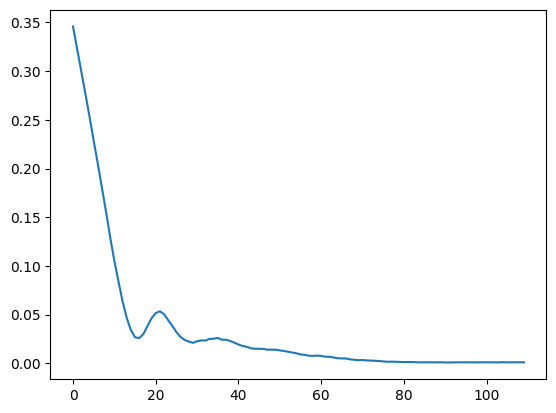

In [35]:
#Train model using the best individual obtained from the genetic algorithm  
optimizer=optimizers.adam_v2.Adam(learning_rate=best_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = Sequential()
model.add(CuDNNLSTM(best_num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1])) 
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
model.summary()

#还需要看是否需要切分验证集。如果有划分验证集，则his中的参数就存在val系列
history=model.fit(x_train_modified, y_train, epochs=best_epoch, batch_size=best_batch_size,verbose=0)

loss = history.history['loss']
plt.plot(loss)

In [36]:
yhat = model.predict(x_test)
print(x_test)
print(yhat)

[[0.35031629]
 [0.34781456]
 [0.85200481]
 [0.49935183]
 [0.42755274]
 [0.51371408]
 [0.66620405]
 [0.68906135]
 [0.45390293]
 [0.44208886]
 [0.5587065 ]
 [0.44199957]
 [0.48526108]
 [0.57747506]
 [0.51325278]
 [0.44877856]
 [0.57753368]
 [0.41591379]
 [0.42504373]
 [0.49898806]
 [0.99913574]
 [0.5602538 ]
 [0.71959564]
 [0.48231815]
 [0.47142874]
 [0.44750029]
 [0.62085567]
 [0.55813853]
 [0.35290229]
 [0.99630266]
 [0.46417958]
 [0.49250207]
 [0.85703779]
 [0.4865302 ]
 [0.41170441]
 [0.59891439]
 [0.3303919 ]
 [0.36454005]
 [0.35992462]
 [0.14288437]
 [0.50058977]
 [0.98933333]
 [0.47386115]
 [0.43368415]
 [0.56211907]
 [0.99890934]
 [0.37215293]
 [0.41902607]
 [0.66201311]
 [0.86969814]
 [0.42995021]
 [0.6134948 ]
 [0.55521015]
 [0.36094166]
 [0.35210591]
 [0.6128623 ]
 [0.37231208]
 [1.        ]
 [0.99448014]
 [0.9902679 ]
 [0.99927923]
 [0.41804754]
 [0.42660093]
 [0.39675101]
 [0.98950605]
 [0.396457  ]
 [0.55186376]
 [0.46490163]
 [0.49105611]
 [0.99019099]
 [0.99760515]
 [0.99